## Access Satellite GHRSST L3S 1day Day and Night Single Sensor Australia data in Zarr
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l3s_1day_daynighttime_single_sensor_australia dataset available as a [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/a136eee7-a990-4c06-a4f6-915657a2464e).

In [1]:
dataset_name = "satellite_ghrsst_l3s_1day_daynighttime_single_sensor_australia"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [3]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 30ms


In [4]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [5]:
from DataQuery import plot_gridded_variable, create_timeseries,plot_time_coverage

In [6]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), chunks=None, consolidated=True)
ds

<xarray.Dataset> Size: 17TB
Dimensions:                  (time: 11870, lat: 4500, lon: 6000)
Coordinates:
  * lat                      (lat) float32 18kB 19.99 19.97 ... -69.97 -69.99
  * lon                      (lon) float32 24kB 70.01 70.03 ... 190.0 190.0
  * time                     (time) datetime64[ns] 95kB 1992-03-21T09:20:00 ....
Data variables:
    dt_analysis              (time, lat, lon) float32 1TB ...
    l2p_flags                (time, lat, lon) float32 1TB ...
    quality_level            (time, lat, lon) float32 1TB ...
    satellite_zenith_angle   (time, lat, lon) float32 1TB ...
    sea_surface_temperature  (time, lat, lon) float32 1TB ...
    sses_bias                (time, lat, lon) float32 1TB ...
    sses_count               (time, lat, lon) float32 1TB ...
    sses_standard_deviation  (time, lat, lon) float32 1TB ...
    sst_count                (time, lat, lon) float32 1TB ...
    sst_dtime                (time, lat, lon) float64 3TB ...
    sst_mean                 (time, lat, lon) float32 1TB ...
    sst_standard_deviation   (time, lat, lon) float32 1TB ...
Attributes: (12/47)
    Conventions:                CF-1.6
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Metadata_Link:              TBA
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              grid
    comment:                    HRPT AVHRR experimental L3 retrieval produced...
    ...                         ...
    summary:                    Skin SST retrievals produced from stitching t...
    time_coverage_end:          20241027T155958Z
    time_coverage_start:        20241026T235617Z
    title:                      IMOS L3S Day and Night gridded multiple-senso...
    uuid:                       4510f333-c151-4c48-883c-dacaa272a627
    westernmost_longitude:      70.01000213623047

## Plot time coverage

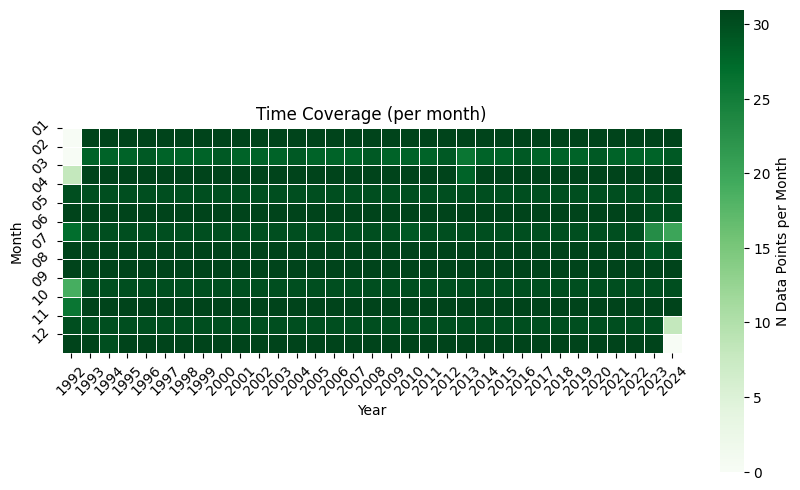

In [7]:
plot_time_coverage(ds)

## Timeseries at a point

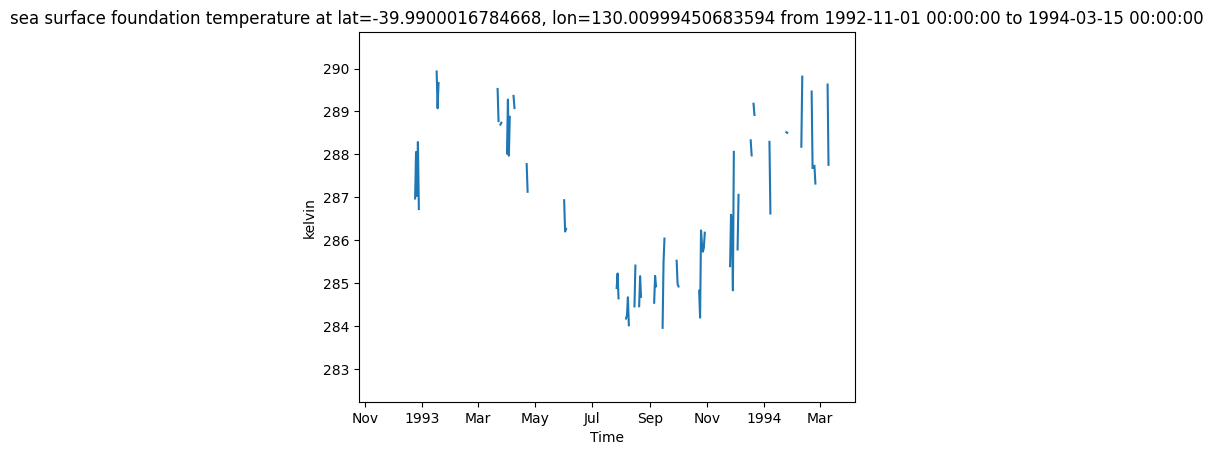

CPU times: user 2.44 s, sys: 545 ms, total: 2.99 s
Wall time: 9.87 s


In [8]:
%%time
time_series_df = create_timeseries(ds, 'sea_surface_temperature', lat=-40, lon=130, start_time='1992-11-01', end_time='1994-03-15')

## Plot a gridded variable

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('1992-06-10T09:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 1992-06-10T09:20:00
Attributes:
    axis:           T
    comment:        A typical reference time for data
    long_name:      reference time of sst file
    standard_name:  time
Variable Long Name: sea surface foundation temperature


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:880: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


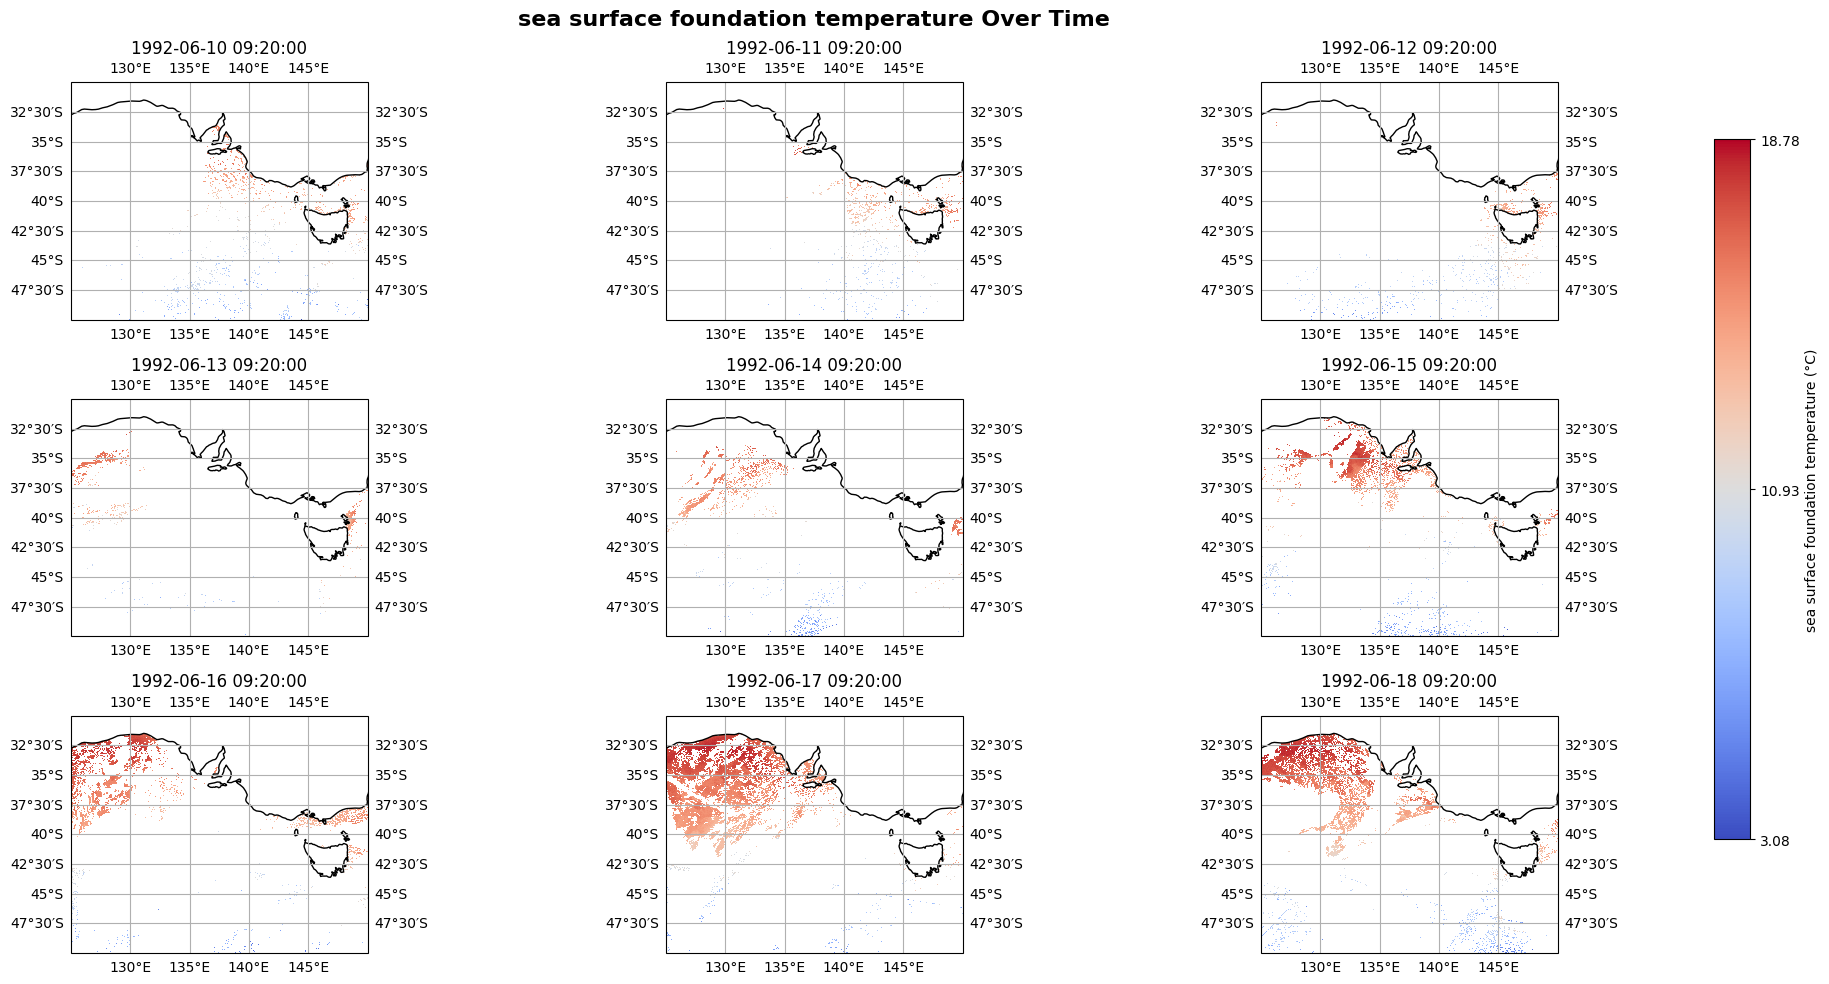

CPU times: user 6.43 s, sys: 4.05 s, total: 10.5 s
Wall time: 8.93 s


In [10]:
%%time
plot_gridded_variable(ds, start_date='1992-06-10', lon_slice=(125, 150), lat_slice=(-50, -30), var_name='sea_surface_temperature', n_days=9, coastline_resolution="50m")